In [4]:
#get_ipython().magic('reset -sf')

# Models

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import neighbors
from sklearn import feature_selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
import time
import dalex as dx
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
from torch.autograd import Variable 
from captum.attr import (
    IntegratedGradients,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import lime.lime_tabular

import matplotlib.pyplot as plt

First, I import pre-cleaned data, after I divide the dataset in training and testing, 60% and 40% respectively. Everything has to be scaled and I prepare the folds for the 5 cross validation. The steps I am going to follow in wach model are the following:
- Recursive feature elimination, I am going to remove the non important features
- Grid search, in order to try all the hyperparameters and choose the best ones
- Create model with the hyperparameters selected previously and fit it
- Make the predictions
- Shapley values to understand the model and the predictions

In [2]:
data_info_original = pd.read_csv('info_data.csv')
data_info_original = data_info_original.sort_values(['ANO_FACTURA', 'MES_FACTURA', 'FECHA_FACTURA'])
data_info = pd.read_csv('info_datav2.csv')
data_info = data_info.sort_values(['ANO_FACTURA', 'MES_FACTURA', 'FECHA_FACTURA'])
data_gaussian = data_info[data_info.ANO_FACTURA == 2020]

C:\Users\cul_g\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def getISOCountry(iso_country):
    indexes = data_info_original[data_info_original['NUMERO_DEUDOR_PAIS_ID'] == iso_country].index
    iso_code = data_info.iloc[[indexes[0]]]['NUMERO_DEUDOR_PAIS_ID']
    return iso_code.values[0]

def getValuesFilter(ds, value, columns, target):
    if value == '*': #no filter 
        return ds
    indexes = getIndexFilter(ds, value, target)
    datat = getValues(ds, indexes, columns)
    return datat

def getIndexFilter(dt, value, target):
    indexes = dt[dt[target] == value].index
    return indexes

def getValues(dt, indexes, columns):
    datat = []
    for k, v in zip(dt.index, dt.values):
        if k in indexes:
            datat.append(v)
    df = pd.DataFrame(datat, columns = columns)
    return df


In [4]:
# Filter data by country
iso_spain = getISOCountry('ES') # Get iso from a country you want  to
data_info_filtered = getValuesFilter(data_info, '*', data_info.columns, 'NUMERO_DEUDOR_PAIS_ID') # iso = * -> no filter by numero deudor pais id
data_info_filtered = data_info_filtered.sort_values(['ANO_FACTURA', 'MES_FACTURA', 'FECHA_FACTURA'])
data_info_original_filtered = getValuesFilter(data_info_original, '*', data_info_original.columns, 'NUMERO_DEUDOR_PAIS_ID') # iso = * -> no filter by numero deudor pais id
data_info_original_filtered = data_info_original_filtered.sort_values(['ANO_FACTURA', 'MES_FACTURA', 'FECHA_FACTURA'])

In [5]:
traindataset_original, testdataset_original = train_test_split(data_info_original_filtered, test_size=0.4, shuffle= False) # To use all the data, change to -> data_info
traindataset, testdataset = train_test_split(data_info_filtered, test_size=0.4, shuffle= False) # To use all the data, change to -> data_info
x_train = traindataset.loc[:, traindataset.columns != 'IMP_VENTA_NETO_EUR']
y_train = traindataset.loc[:, traindataset.columns == 'IMP_VENTA_NETO_EUR']
x_train = x_train.drop(columns=['EDAD_RANGO_COMPRA'])
x_test = testdataset.loc[:, testdataset.columns != 'IMP_VENTA_NETO_EUR']
y_test = testdataset.loc[:, testdataset.columns == 'IMP_VENTA_NETO_EUR']
x_test = x_test.drop(columns = 'EDAD_RANGO_COMPRA')

In [6]:
#scaler = StandardScaler()
#x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
#x_test = pd.DataFrame(scaler.fit_transform(x_test), columns = x_test.columns)
normalizer = MinMaxScaler(feature_range = (-1, 1))
x_train = pd.DataFrame(normalizer.fit_transform(x_train), columns= x_train.columns)
x_test = pd.DataFrame(normalizer.fit_transform(x_test), columns= x_test.columns)
mseresults = pd.DataFrame()
timeexecution = pd.DataFrame()

In [7]:
folds = KFold(n_splits = 5, shuffle = False) # if shuffle false, random state doesn't matter

## Linear Model

I have to choose which are the most important features in the model, I will use R2 to get it.

In [ ]:
hyper_params = [{'n_features_to_select': list(range(1, 26))}]
lm = LinearRegression()
rfe = RFE(lm)
model_cv = GridSearchCV(estimator = rfe, param_grid = hyper_params, scoring= 'r2', cv = folds, verbose = 1, return_train_score=True)      
model_cv.fit(x_train, y_train)
cv_results = pd.DataFrame(model_cv.cv_results_)

In [ ]:
display(cv_results)
print(model_cv.best_params_)

In [ ]:
#plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
plt.savefig('../Output/testscoretrain.png')
plt.show()

display(cv_results[['param_n_features_to_select', 'mean_train_score', 'mean_test_score']])

In [9]:
n_features_optimal = 25 # Put the best parametrization Check if the previous RFE has the parameters -> Yes: Don't use this, take them directly
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select= n_features_optimal)             
rfe = rfe.fit(x_train, y_train)

I select only the parameters I am interested in

In [10]:
chosen = pd.DataFrame(rfe.support_, index=x_train.columns, columns=['Rank'])
featuresnotselected = []
for k, v in zip(chosen.index, chosen.values):
    if v == False:
        featuresnotselected.append(k)
x_train_final = x_train.drop(columns= featuresnotselected)
x_test_final = x_test.drop(columns= featuresnotselected)

Finally, I create the model with the best parametrization possible

In [11]:
lm = LinearRegression()
start_time = time.time()
lm.fit(x_train_final, y_train)
timeexecution['lm'] = (time.time() - start_time)
y_pred = lm.predict(x_test_final)
results = y_test.copy()
results['lm'] = y_pred

In [12]:
display(results)

#De moment no ho utilitzar�
F-test, p-values:

In [ ]:
f_val, p_val = feature_selection.f_regression(x_train_final, y_train) #Repassar
display(list(zip(x_train_final.columns, p_val)))
print('')
display(list(zip(x_train_final.columns, f_val)))

In [13]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2: ', metrics.r2_score(y_test, y_pred))
mseresults['lm'] = metrics.mean_squared_error(y_test, y_pred)

In [ ]:
plt.barh(range(0, 25), lm.coef_[0])
plt.yticks(range(0, 25), x_train_final.columns, fontsize = 8)
plt.title('Coefficients')
plt.savefig('../Output/coefflinear.png')
plt.show()

In [ ]:
variable_groups = {
    'Date': ['ANO_FACTURA', 'MES_FACTURA', 'FECHA_FACTURA', 'TEMPORADA_COMERCIAL_ID'],
    'Product': ['PRODUCTO_ID', 'TALLA', 'GRUPO_ARTICULO_PRODUCTO_ID', 'GENERO_PRODUCTO', 'CATEGORIA', 'TIPOLOGIA', 'CONSUMER_COLOR', 'CREMALLERA', 'CORDONES', 'OUTSOLE_SUELA_TIPO', 'OUTSOLE_SUELA_SUBTIPO', 'PLANTILLA_EXTRAIBLE'],
    'Age': ['EDAD_SN', 'EDAD_COMPRA'],
    'ContanctInfo': ['NUMERO_DEUDOR_PAIS_ID', 'CIUDAD_CONTACTO', 'IDIOMA_CONTACTO', 'GENERO_CONTACTO', 'CONTACTO_SN'],
    'SalePerson': ['ESFUERZO_VENTA_ID']
}

In [ ]:
linear_explainer = dx.Explainer(lm, x_test_final, y_test)
explanation = linear_explainer.model_parts()
explanation.plot()
groupedexpl = linear_explainer.model_parts(variable_groups=variable_groups)
groupedexpl.plot()

In [ ]:
bd_henry = linear_explainer.predict_parts(x_test_final.iloc[[20]], type = 'shap', B= 100)
bd_henry.plot()

In [ ]:
bd_henry = linear_explainer.predict_parts(x_test_final.iloc[[100]], type = 'shap', B= 100)
bd_henry.plot()

In [ ]:
display(testdataset.iloc[[100]])

## XGBoost Model

For this model, I am going to work with, the parameters max_depth, learning_rate and subsample from the Xgboost model and n_features_to_select from RFE.

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

In [40]:
hyper_params = {'estimator__max_depth':[1, 10, 15], 'estimator__n_estimators': [150, 300, 500], 'estimator__learning_rate':[0.1, 0.05, 0.01] }#, 'n_features_to_select': list(range(1, 26))}
num_rounds = 1500
xgbm = xgb.XGBRegressor()
#rfe_xgboost = RFE(xgbm)
model_cv_xgb = GridSearchCV(estimator = xgbm, param_grid = hyper_params, scoring= 'r2', cv = folds, verbose = 1, return_train_score=True)      
model_cv_xgb.fit(x_train, y_train)
cv_results = pd.DataFrame(model_cv.cv_results_)

Once I get the best parametrization, I execute the model with it, by the moment this is an example because I haven't execute the previous, too long.

In [23]:
xgbm = xgb.XGBRegressor(learning_rate =0.01, n_estimators=500, max_depth=15, min_child_weight=1, subsample=0.8, nthread=4, seed=39931191, verbose_eval = True)
start_time = time.time()
xgbm.fit(x_train, y_train)
timeexecution['xgboost'] = (time.time() - start_time)
y_pred = xgbm.predict(x_test)

In [ ]:
#results = y_test.copy()
results['xgboost'] = y_pred

In [24]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))
mseresults['xgboost'] = metrics.mean_squared_error(y_test, y_pred)

Firstly, I create an explainer for the model, the inputs are the model, x_train and y_train. After, i can get the variable importance and the reverse cumulative distribution of residuals

In [28]:
explainer = dx.Explainer(xgbm, x_train, y_train)
explanation = explainer.model_parts()
explanation.plot()
print(explainer.model_performance().result)
res = explainer.model_performance(model_type='regression')
#res.plot()

Also, I can group the features into a new ones. In this case, I have created different variables that include a similar meaning.
- Date: ANO_FACTURA, MES_FACTURA, FECHA_FACTURA, TEMPORADA_COMERCIAL_ID
- Product: PRODUCTO_ID, TALLA, GRUPO_ARTICULO_PRODUCTO_ID, GENERO_PRODUCTO, CATEGORIA, TIPOLOGIA, CONSUMER_COLOR, CREMALLERA, CORDONES, OUTSOLE_SUELA_TIPO, OUTSOLE_SUELA_SUBTIPO, PLANTILLA_EXTRAIBLE
- Age: EDAD_SN, EDAD_COMPRA
- ContanctInfo: NUMERO_DEUDOR_PAIS_ID, CIUDAD_CONTACTO, IDIOMA_CONTACTO, GENERO_CONTACTO, CONTACTO_SN
- SalePerson: ESFUERZO_VENTA_ID

In [29]:
vars_grouped = explainer.model_parts(variable_groups= variable_groups)
print(vars_grouped.result)
vars_grouped.plot()

In [ ]:
sh = explainer.predict_parts(x_test.iloc[[20]], type = 'shap')
sh.plot()
display(testdataset.iloc[[20]])

In [ ]:
sh = explainer.predict_parts(x_test.iloc[[100]], type = 'shap')
sh.plot()
display(testdataset.iloc[[100]])

In [ ]:
#plt.figure(figsize=(16,6))
#chosen = pd.DataFrame(rfe_xgboost.support_, index=x_train.columns, columns=['Rank'])
#featuresnotselected = []
#for k, v in zip(chosen.index, chosen.values):
#    if v == False:
#        featuresnotselected.append(k)
#x_train_final = x_train.drop(columns= featuresnotselected)
#x_test_final = x_test.drop(columns= featuresnotselected)

#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
#plt.xlabel('number of features')
#plt.ylabel('r-squared')
#plt.title("Optimal Number of Features")
#plt.legend(['test score', 'train score'], loc='upper left')

## k-nearest neighbour regression

In [ ]:
rmse_val = [] #to store rmse values for different k
mse_val = []
model = neighbors.KNeighborsRegressor(n_neighbors = 7)
start_time = time.time()
model.fit(x_train, y_train)  #fit the model
timeexecution['knn'] = (time.time() - start_time)
y_pred=model.predict(x_test) #make prediction on test set
mse = metrics.mean_squared_error(y_test, y_pred)
error = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) #calculate rmse
rmse_val.append(error) #store rmse values
mse_val.append(mse)
results['knn'] = y_pred
mseresults['knn'] = metrics.mean_squared_error(y_test, y_pred)

In [ ]:
#curvermse = pd.DataFrame(rmse_val) #elbow curve 
#curvermse.plot()
#curvemse = pd.DataFrame(mse_val)
#curvemse.plot()

## NN

In [25]:
nn_reg = MLPRegressor(hidden_layer_sizes=(300, 300),  activation='logistic', solver='adam', alpha=0.01, batch_size='auto', learning_rate='constant', learning_rate_init=0.01, max_iter=1000, shuffle=False, tol=0.0001, verbose=True, early_stopping= True, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
nn_reg.fit(x_train, np.ravel(y_train))
y_pred = nn_reg.predict(x_test)
nn_reg.score(x_test, y_test)

In [26]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

In [75]:
nn_reg_pred = lambda x: nn_reg.predict(x).astype(float)

In [ ]:
results['nn'] = y_pred

In [130]:
indexspaindata = getIndexFilter(testdataset, 14, 'NUMERO_DEUDOR_PAIS_ID')
indexspaindata_original = getIndexFilter(testdataset_original, 'ES', 'NUMERO_DEUDOR_PAIS_ID')
print(indexspaindata)
print(indexspaindata_original)

In [123]:
display(testdataset.loc[indexspaindata[0]])
display(testdataset_original.loc[indexspaindata_original[0]])
display(testdataset_original[(testdataset_original['PRODUCTO_ID'] == 10189) & (testdataset_original['NUMERO_DEUDOR_PAIS_ID'] == 'ES') & (test)].index)
display(testdataset_original.loc[[644943]])
i=0
for v in indexspaindata_original:
    if v == 644943:
        break
    else:
        i = i+1
print(i)


In [101]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x_train.columns, verbose=True, mode='regression')
exp = explainer.explain_instance(np.ravel(x_test.iloc[[indexspaindata[0]]]), nn_reg_pred, num_features=10)
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

In [102]:
exp.as_list()

In [68]:
display(testdataset.iloc[[100]])
display(y_pred[100])

## LSTM

In [53]:
torch.manual_seed(39931191)
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 5) #fully connected 1
        self.fc = nn.Linear(5, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0.detach(), c_0.detach())) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Densetarget.squeeze(1)
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [9]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.01 #0.001 lr

input_size = 25 #number of features
hidden_size = 20 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

x_train_tensors = Variable(torch.Tensor(x_train.values))
x_test_tensors = Variable(torch.Tensor(x_test.values))
y_train_tensors = Variable(torch.Tensor(y_train.values))
y_test_tensors = Variable(torch.Tensor(y_test.values))

x_train_tensors_final = torch.reshape(x_train_tensors,   (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))


x_test_tensors_final = torch.reshape(x_test_tensors,  (x_test_tensors.shape[0], 1, x_test_tensors.shape[1]))

torch.Size([644326, 25])

In [10]:
lstm1 = LSTM(num_classes, input_size, hidden_size, num_layers, x_train_tensors_final.shape[1]) #our lstm class

In [11]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [12]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(x_train_tensors_final) #forward pass
  #outputs = lstm2.forward(x_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 13657.66016
Epoch: 100, loss: 2451.79053
Epoch: 200, loss: 1461.70215
Epoch: 300, loss: 1278.39465
Epoch: 400, loss: 1135.55652
Epoch: 500, loss: 1010.02942
Epoch: 600, loss: 945.15948
Epoch: 700, loss: 893.12262
Epoch: 800, loss: 837.27686
Epoch: 900, loss: 792.25140
Epoch: 1000, loss: 745.21283
Epoch: 1100, loss: 710.76758
Epoch: 1200, loss: 685.38440
Epoch: 1300, loss: 672.82355
Epoch: 1400, loss: 653.83765
Epoch: 1500, loss: 642.23291
Epoch: 1600, loss: 632.60480
Epoch: 1700, loss: 625.80524
Epoch: 1800, loss: 619.40936
Epoch: 1900, loss: 614.26550


In [16]:
train_predict = lstm1(x_test_tensors_final)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
#plt.axvline(x=200, c='r', linestyle='--') #size of the training set
#print(y_test, data_predict)
#plt.scatter(range(0, 5),y_test[:5], label='Actual Data') #actual plot
#plt.scatter(range(0, 5), data_predict[:5], label='Predicted Data') #predicted plot
#plt.title('Time-Series Prediction')
#plt.legend()
#plt.show()

In [17]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, data_predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, data_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, data_predict)))
print('R2:', metrics.r2_score(y_test, data_predict))

Mean Absolute Error: 32.77718789269531
Mean Squared Error: 1881.2197175686686
Root Mean Squared Error: 43.37302984077396
R2: 0.060144911772238574


In [52]:
ig = IntegratedGradients(lstm1)
#input = torch.randn(, requires_grad=True)
t = torch.Tensor(x_test.iloc[[20]].values)
# Computes integrated gradients for class 3.

x_test_tensors_final = torch.reshape(x_test_tensors,  (x_test_tensors.shape[0], 1, x_test_tensors.shape[1]))
x_test_tensors_final_ig = torch.reshape(x_test_tensors_final[0],  (1, 1, 25))
#x_test_tensors_final_ig.shape
attribution = ig.attribute(x_test_tensors_final_ig)
x_test_tensors_final_ig
display(attribution.detach().numpy()[0][0])

array([-1.09832373e+02, -4.28888033e+01,  1.02537317e+00,  1.14352918e+02,
       -2.21643133e+01,  5.49921159e+00, -1.16096110e+00, -2.19670232e+01,
        4.40289065e+01, -5.98357225e+01,  5.76655491e+00, -3.43444829e+01,
        2.09977373e+00, -8.70521950e-02, -4.47929556e+00, -5.69581685e-01,
        1.13687973e+01,  7.02857070e-01,  4.59351421e-01,  4.22111583e+00,
       -5.14953529e+00,  6.42022664e-01, -9.39428773e-01, -1.30650051e-01,
       -9.62223256e+00])

In [61]:
def visualize_importance(title, features, importance, xtitle):
    plt.barh(range(0, features.size), importance, align = 'center')
    plt.yticks(range(0, features.size), features, wrap = True)
    plt.ylabel(xtitle)
    plt.title(title)
    plt.show()

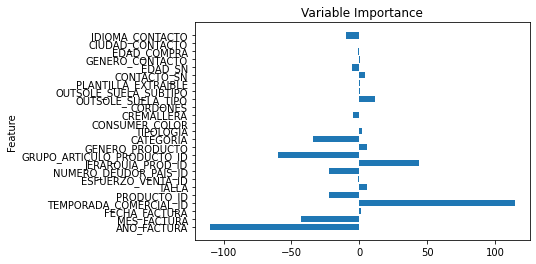

In [62]:
visualize_importance('Variable Importance', x_test.columns, attribution.detach().numpy()[0][0], 'Feature')

In [51]:
range(0, x_test.columns.size)

range(0, 25)

## Gaussian process regression

In [ ]:
#params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

#knn = neighbors.KNeighborsRegressor()

#model = GridSearchCV(knn, params, cv=10)
#model.fit(x_train,y_train)
#model.best_params_

In [22]:
data_gaussian_filtered = getValuesFilter(data_gaussian, 14, data_gaussian.columns) # iso = * -> no filter by numero deudor pais id
data_gaussian_filtered = data_gaussian_filtered.sort_values(['ANO_FACTURA', 'MES_FACTURA', 'FECHA_FACTURA'])
traindataset, testdataset = train_test_split(data_gaussian, test_size=0.01, shuffle= False)
traindataset, testdataset = train_test_split(testdataset, test_size=0.01, shuffle= False)
x_train = traindataset.loc[:, traindataset.columns != 'IMP_VENTA_NETO_EUR']
y_train = traindataset.loc[:, traindataset.columns == 'IMP_VENTA_NETO_EUR']
x_train = x_train.drop(columns=['EDAD_RANGO_COMPRA'])
x_test = testdataset.loc[:, testdataset.columns != 'IMP_VENTA_NETO_EUR']
y_test = testdataset.loc[:, testdataset.columns == 'IMP_VENTA_NETO_EUR']
x_test = x_test.drop(columns = 'EDAD_RANGO_COMPRA')
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns = x_test.columns)
traindataset.shape

In [23]:
# massive dataset, try with something smaller
kernel = kernel = RBF(10, (1e-2, 1e2)) # Check which ones choose
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gpr.fit(x_train, y_train)
gpr.score(x_train, y_train)
y_pred, sigma = gpr.predict(x_test, return_std=True)
results['gaussianP'] = y_pred

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))